In [26]:
import zipfile
import os 
import torch
from torch import nn
from torch.utils.data import Dataset, dataloader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
from skimage import color
from torch.nn.functional import relu
from random import randint
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

device used : cuda


In [27]:


# local_zip = './DIV2K_train_LR_x8.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('.')
# zip_ref.close()

# local_zip = './DIV2K_valid_LR_x8.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('.')
# zip_ref.close()

# train_directory = './DIV2K_train_LR_x8'
# test_directory = './DIV2K_valid_LR_x8'

In [28]:
# class ImageDataset(Dataset):
#     def __init__(self, directory, transform=None):
#         self.directory = directory
#         self.transform = transform
#         self.dataset = os.listdir(directory)
    
#     def __len__(self):
#         return len(self.dataset)
    
#     def __getitem__(self, idx):
#         image = plt.imread(os.path.join(self.directory, self.dataset[idx]))
#         if self.transform:
#             image = self.transform(image)
#         return image[0,...].unsqueeze(0), image[1:,...]

In [29]:
SIZE = 128  
def choose_pixel():
    return (randint(0, SIZE-1), randint(0, SIZE-1))

def ab_percent(percent=0.01):
    return int(SIZE**2 * percent)

class CustomFlowersDataset(Dataset):
    def __init__(self, root, split="train", transform=None, download=False):
        self.flowers_dataset = Flowers102(root=root, split=split, download=download)
        self.transform = transform

    def __getitem__(self, index):
        image, _ = self.flowers_dataset[index]


        if self.transform is not None:
            image = self.transform(image)


        l_channel = image[0, ...].unsqueeze(0)
        a_channel = image[1, ...].unsqueeze(0)
        b_channel = image[2, ...].unsqueeze(0)

        modified_a_channel = torch.zeros_like(a_channel)
        modified_b_channel = torch.zeros_like(b_channel)

        num_pixels_to_modify = ab_percent()
        
        for i in range(num_pixels_to_modify):
            chosen_pixel = choose_pixel()
            chosen_pixel_color = image[:, chosen_pixel[0], chosen_pixel[1]].unsqueeze(1).unsqueeze(2)
            modified_a_channel[:, chosen_pixel[0], chosen_pixel[1]] = chosen_pixel_color[1, 0, 0]
            modified_b_channel[:, chosen_pixel[0], chosen_pixel[1]] = chosen_pixel_color[2, 0, 0]

        lab_image = torch.cat([l_channel, modified_a_channel, modified_b_channel], dim=0)

        return lab_image, image[1:, ...]

    def __len__(self):
        return len(self.flowers_dataset)


In [30]:
root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((128,128), antialias=True),
])

train_dataset = CustomFlowersDataset(root=root_dir, split="train", transform=transform, download=False)
test_dataset = CustomFlowersDataset(root=root_dir, split="test", transform=transform, download=False)
# train_dataset = ImageDataset(train_directory, transform=transform)
# test_dataset = ImageDataset(test_directory, transform=transform)

Train dataset size: 1020
Test dataset size: 6149


Images shapes :torch.Size([3, 128, 128]) (input)
Images shapes :torch.Size([3, 128, 128]) (target)


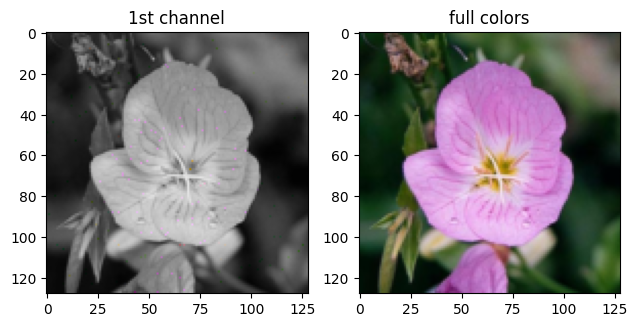

In [31]:
def tensorToImg(tensor:torch.Tensor):
	return tensor.moveaxis(0,2).detach().cpu().numpy()

print("Train dataset size:",len(train_dataset))
print("Test dataset size:",len(test_dataset))
img1, img2 = test_dataset[0]
print(f"Images shapes :{img1.shape} (input)")



fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)

ax1.imshow(color.lab2rgb(tensorToImg(img1)), cmap="grey")
ax1.set_title("1st channel")

img_colored = torch.cat((img1[0].unsqueeze(0), img2), dim=0)

print(f"Images shapes :{img_colored.shape} (target)")

ax2.imshow(color.lab2rgb(tensorToImg(img_colored)))
ax2.set_title("full colors")
plt.tight_layout()

In [32]:
class ColorNN(nn.Module):
	def __init__(self, *args, **kwargs) -> None:
		super().__init__(*args, **kwargs)
		self.conv1 = self.DoubleConv2d(1, 3)
		self.conv2 = self.DoubleConv2d(3, 64)
		self.conv3 = nn.Sequential(
			nn.Conv2d(64, 128, 3, 2, 1, padding_mode="replicate"),
			nn.ReLU()
		)
		self.conv4 = nn.Sequential(
			nn.Conv2d(128, 256, 3, 2, 1, padding_mode="replicate"),
			nn.ReLU()
		)

		self.conv5 = self.DoubleConv2d(451, 128)
		self.conv6 = self.DoubleConv2d(128, 16)
	
		self.conv7 = self.DoubleConv2d(144, 32)
		self.conv8 = self.DoubleConv2d(32, 1)

	def forward(self, X):
		
		X_1 = self.conv1(X)
		X_2 = self.conv2(X_1)
		X_3 = self.conv3(X_2)
		X_4 = self.conv4(X_3)
		X_5 = self.conv5(torch.concat([X_1,X_2,nn.Upsample(scale_factor=2)(X_3),nn.Upsample(scale_factor=4)(X_4)],dim = 1))
		X_6 = self.conv6(X_5)
		return torch.cat((X, self.conv8(self.conv7(torch.cat((X_5, X_6), dim=1)))), dim=1)
	
		
	
	def DoubleConv2d(self, c_in, c_out, k_size=3, stride=1, padding=1, padding_mode="replicate"):
		return nn.Sequential(
			nn.Conv2d(c_in, c_out, k_size, stride, padding, padding_mode=padding_mode),
			nn.ReLU(),
			# nn.Conv2d(c_out, c_out, k_size, stride, padding, padding_mode=padding_mode),
			# nn.ReLU()
		)

In [51]:

class NetworkColor(nn.Module):
    def __init__(self):
        """
        Initializes each part of the convolutional neural network.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.t_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.t_conv1_bn = nn.BatchNorm2d(32)
        self.t_conv2 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        """
        Implements the forward pass for the given data `x`.
        :param x: The input data.
        :return: The neural network output.
        """
        x = relu(self.conv1_bn(self.conv1(x)))
        x = relu(self.conv2_bn(self.conv2(x)))

        x = relu(self.t_conv1_bn(self.t_conv1(x)))
        x = relu(self.t_conv2(x))
        return x

In [34]:
class NetworkColor2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)

        # Dilation layers.
        self.conv5 = nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=3, dilation=2)
        self.conv5_bn = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=3, dilation=2)
        self.conv6_bn = nn.BatchNorm2d(256)

        self.t_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.t_conv1_bn = nn.BatchNorm2d(128)
        self.t_conv2 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)
        self.t_conv2_bn = nn.BatchNorm2d(64)
        self.t_conv3 = nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1)
        self.t_conv3_bn = nn.BatchNorm2d(32)
        self.t_conv4 = nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1)

        self.output = nn.Conv2d(3, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        """
        Implements the forward pass for the given data `x`.
        :param x: The input data.
        :return: The neural network output.
        """
        x_1 = relu(self.conv1_bn(self.conv1(x)))
        x_2 = relu(self.conv2_bn(self.conv2(x_1)))
        x_3 = relu(self.conv3_bn(self.conv3(x_2)))
        x_4 = relu(self.conv4_bn(self.conv4(x_3)))

        # Dilation layers.
        x_5 = relu(self.conv5_bn(self.conv5(x_4)))
        x_5_d = relu(self.conv6_bn(self.conv6(x_5)))

        x_6 = relu(self.t_conv1_bn(self.t_conv1(x_5_d)))
        x_6 = torch.cat((x_6, x_3), 1)
        x_7 = relu(self.t_conv2_bn(self.t_conv2(x_6)))
        x_7 = torch.cat((x_7, x_2), 1)
        x_8 = relu(self.t_conv3_bn(self.t_conv3(x_7)))
        x_8 = torch.cat((x_8, x_1), 1)
        x_9 = relu(self.t_conv4(x_8))
        x_9 = torch.cat((x_9, x), 1)
        x = self.output(x_9)
        return x

In [52]:
# Define the model
model = NetworkColor().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





In [36]:
# Dataloaders
train_dataset = [train_dataset[i] for i in range(len(train_dataset))]
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader = dataloader.DataLoader(test_dataset, shuffle=True, batch_size=64)


In [47]:



# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
	size = len(dataloader.dataset)
	
	model.train()
	
	for batch, (X, y) in enumerate(dataloader):
		# Compute prediction and loss
		X = X.to(device)
		y = y.to(device)
		pred = model(X)
		loss = loss_fn(pred, y)

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 10 == 0:
			loss, current = loss.item(), (batch + 1) * len(X)
			print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
	return loss.item()


In [48]:
def select_n_random(data, n=3):
    perm = torch.randperm(len(data))
    listData = [data[perm[i]] for i in range(n)]
    return listData


def plot_images_colorization(model, data):
    model.eval()
    
    fig = plt.figure()
    axes = fig.subplots(len(data), 3)
    for i, (ax1, ax2, ax3) in enumerate(axes):
        img1, img2 = data[i]
        img1 = img1.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(img1).to(device)
        img1 = img1[0][0].unsqueeze(0)
        out = torch.cat((img1, out[0]), dim=0).to(device)
        img1 = img1.cpu()
        ax1.imshow(img1.moveaxis(0, 2), cmap="grey")
        ax2.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))
        img2 = torch.cat((img1, img2), dim=0)
        ax3.imshow(color.lab2rgb(img2.moveaxis(0, 2).cpu()))
        ax1.axis("off")
        ax2.axis("off")
        ax3.axis("off")
    return fig

In [53]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Set the number of epochs
num_epochs = 100

train_acc = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_loader, model, criterion, optimizer)
    writer.add_scalar("Loss/train", loss, t)
    if (t+1) % 10 == 0:
        data = select_n_random(train_dataset, n=4)
        writer.add_figure('grey/colorized/real',
                            plot_images_colorization(model,data),
                            global_step=t+1)
        writer.flush()
        

print("Done!")
writer.close()



Epoch 1
-------------------------------
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
loss: 661.975403  [   64/ 1020]
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
loss: 656.072876  [  704/ 1020]
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 12

C:\Users\thiba\AppData\Local\Temp\ipykernel_47384\148180276.py:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  ax2.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))


Epoch 41
-------------------------------
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
loss: 273.762085  [   64/ 1020]
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
loss: 286.547119  [  704/ 1020]
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 1

C:\Users\thiba\AppData\Local\Temp\ipykernel_47384\148180276.py:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  ax2.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))


Epoch 81
-------------------------------
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
loss: 280.384155  [   64/ 1020]
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
loss: 228.090561  [  704/ 1020]
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 1

C:\Users\thiba\AppData\Local\Temp\ipykernel_47384\148180276.py:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 25 negative Z values that have been clipped to zero
  ax2.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))


Epoch 91
-------------------------------
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
loss: 247.839172  [   64/ 1020]
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
loss: 221.407837  [  704/ 1020]
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 2, 128, 1

C:\Users\thiba\AppData\Local\Temp\ipykernel_47384\148180276.py:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  ax2.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))


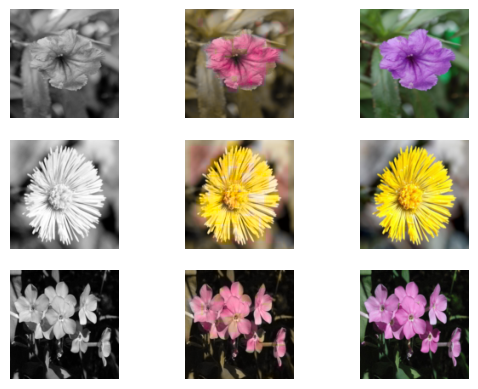

In [54]:
data = select_n_random(train_dataset, n=3)

fig = plot_images_colorization(model, data)


In [ ]:
save = True

if save:
    torch.save(model.state_dict(), "./model.pth")

In [ ]:
import numpy as np
model = NetworkColor()
model.load_state_dict(torch.load('./model.pth'))
model.to(device)
model.eval()
def colorize_image(input_image, output_image):
    colorized_image = torch.cat((input_image, output_image[0]), dim=0)
    colorized_image = colorized_image.detach().moveaxis(0, 2).cpu()
    colorized_image_rgb = color.lab2rgb(colorized_image)
    return (colorized_image_rgb * 255).astype(np.uint8)


img1, img2 = data[0]
img1 = img1.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(img1)

img1 = img1[0]

colorize_image(img1.to(device), output.to(device))
plt.show()